In [2]:
from mp_api.client import MPRester
import pandas as pd

API_KEY = "4IeHY5jVcrgiKXNuAo6Jgs7yC0Z3hsli"

try:
    with MPRester(API_KEY) as mpr:
        # Search for materials with a band gap greater than 0.5 eV and check stability
        docs = mpr.materials.summary.search(
            band_gap=[0.5, None], # band_gap greater than or equal to 0.5 eV
            is_stable=True,       # material is stable (on the convex hull)
            fields=["material_id", "formula_pretty", "band_gap", "is_stable"] # request specific fields
        )

        print(f"Found {len(docs)} stable materials with a band gap >= 0.5 eV.\n")

        # Iterate through the results and print the data
        print("{:<15} {:<15} {:<15} {:<10}".format("Material ID", "Formula", "Band Gap (eV)", "Is Stable"))
        print("-" * 55)
        for doc in docs[:10]: # Print the first 10 results
            print("{:<15} {:<15} {:<15.3f} {:<10}".format(
                doc.material_id,
                doc.formula_pretty,
                doc.band_gap,
                doc.is_stable
            ))

except Exception as e:
    print(f"An error occurred: {e}")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Retrieving SummaryDoc documents: 100%|██████████| 15179/15179 [00:04<00:00, 3053.69it/s]

Found 15179 stable materials with a band gap >= 0.5 eV.

Material ID     Formula         Band Gap (eV)   Is Stable 
-------------------------------------------------------
mp-11107        Ac2O3           3.523           1         
mp-32800        Ac2S3           2.296           1         
mp-1183115      AcAlO3          4.102           1         
mp-27972        AcBr3           4.103           1         
mp-30274        AcBrO           4.241           1         
mp-27971        AcCl3           5.087           1         
mp-30273        AcClO           4.445           1         
mp-866101       AcCrO3          2.003           1         
mp-985278       AcF3            6.069           1         
mp-861502       AcFeO3          0.989           1         


Code above uses MPRester Python client to access the Materials Project database. Using the client and API key, the code searches for all materials in the dataset that fulfill requirements, such as band gap, stability, and fields. The code then prints the first 10 materials found and displays a table that shows the material id, formula, band gap, and stability for each material.

In [4]:
#Use to display info on specific battery material id

with MPRester(API_KEY) as mpr:
    # Query for the specific battery_id
    # Note: Use mpr.materials.insertion_electrodes to avoid deprecation warnings
    docs = mpr.materials.insertion_electrodes.search(battery_ids="mp-976060_Li")

    if docs:
        # Convert the first (and only) matching document to a dictionary
        battery_data = docs[0].dict()

        # Method 1: Display as a readable DataFrame (Transposed for easier reading)
        df7 = pd.DataFrame([battery_data]).T
        df7.columns = ["Value"]
        print(df7)

        # Method 2: Print as a formatted JSON-like dictionary
        # import json
        # print(json.dumps(battery_data, indent=4, default=str))
    else:
        print("No battery data found for this ID.")

Retrieving InsertionElectrodeDoc documents: 100%|██████████| 1/1 [00:00<00:00, 21845.33it/s]

                                                                         Value
battery_type                                                         insertion
battery_id                                                        mp-976060_Li
thermo_type                                                               None
battery_formula                                                         Li2-3C
working_ion                                                                 Li
num_steps                                                                    1
max_voltage_step                                                           0.0
last_updated                                  2025-09-19 09:44:52.679315+00:00
framework                                                           {'C': 1.0}
framework_formula                                                            C
elements                                                                   [C]
nelements                                           

Code above asks for material id, then prints all the information on the dataset about the corresponding material.

In [ ]:
#Use to display info on specific battery material id

with MPRester(API_KEY) as mpr:
    # Query for the specific battery_id
    # Note: Use mpr.materials.insertion_electrodes to avoid deprecation warnings
    docs = mpr.materials.insertion_electrodes.search(battery_ids="mp-985585_Li")

    if docs:
        # Convert the first (and only) matching document to a dictionary
        battery_data = docs[0].dict()

        # Method 1: Display as a readable DataFrame (Transposed for easier reading)
        df7 = pd.DataFrame([battery_data]).T
        df7.columns = ["Value"]
        print(df7)

        # Method 2: Print as a formatted JSON-like dictionary
        # import json
        # print(json.dumps(battery_data, indent=4, default=str))
    else:
        print("No battery data found for this ID.")

In [6]:
from mp_api.client import MPRester
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

API_KEY = "4IeHY5jVcrgiKXNuAo6Jgs7yC0Z3hsli"

with MPRester(API_KEY) as mpr:
    # Pull summary data
    materials = mpr.materials.insertion_electrodes.search(
            working_ion=["Li","Mg"],
            fields=[
                "battery_id", "battery_formula", "average_voltage", "capacity_grav", "energy_grav", "stability_charge", "max_delta_volume"
            ]
        )

# Iterates for each material
# Attributes into dictionaries
# Convert to DataFrame
mp_df = pd.DataFrame([{
    "battery_id": m.battery_id,
    "battery_formula": m.battery_formula,
    "average_voltage": m.average_voltage,
    "capacity_grav": m.capacity_grav,
    "energy_grav": m.energy_grav,
    "max_delta_volume": m.max_delta_volume,
} for m in materials])



# Drop any rows with missing values (critical)
mp_df = mp_df.dropna().reset_index(drop=True)

mp_df = mp_df[mp_df["max_delta_volume"] > 0.100] # Constraints

# Verify data exists
print("Number of materials pulled:", len(mp_df))
if len(mp_df) == 0:
    raise ValueError("No materials data available after dropping missing values!")

# -------------------------------
# Normalize and prepare features
# -------------------------------
features = ["average_voltage", "capacity_grav", "energy_grav", "max_delta_volume"] # Feature(s) to score based on
#Min max normalization values to scale in range [0,1]
# Xscaled = (X - Xmin) / (Xmax - Xmin)
scaler = MinMaxScaler()
mp_df[features] = scaler.fit_transform(mp_df[features])

weights = [0.2, 0.25, 0.3, 0.25]

# Invert features where lower is better
for col in ["max_delta_volume"]: #add features to be flipped here
    mp_df[col] = 1 - mp_df[col]


weights = { # Weights for each property
    "average_voltage": 0.3,
    "capacity_grav": 0.4,
    "energy_grav": 0.2,
    "max_delta_volume": 0.1
}

mp_df["weighted_score"] = sum( #multiply by respective weight for each property in each material
    mp_df[col] * w for col, w in weights.items()
)
# Compute composite score
mp_df["overall_score"] = mp_df[features].mean(axis=1)

# -------------------------------
# Rank and select top candidates
# -------------------------------
top_candidates = mp_df.sort_values("overall_score", ascending=False).head(20)
top_weighted_candidates = mp_df.sort_values("weighted_score", ascending=False).head(20)



# Print best candidates
print("Top candidates based on intrinsic score:")
print(top_candidates[["battery_id", "battery_formula", "overall_score"]])
print("\nTop candidates based on weighted score:")
print(top_weighted_candidates[["battery_id", "battery_formula", "weighted_score"]])


Retrieving InsertionElectrodeDoc documents: 100%|██████████| 4742/4742 [00:00<00:00, 7092.56it/s]

Number of materials pulled: 1097
Top candidates based on intrinsic score:
        battery_id battery_formula  overall_score
414   mp-985585_Li        Li0-3ClO       0.768834
469  mp-1189643_Li   Li0-1Co(CO3)2       0.603763
723  mp-1402637_Mg       Mg0-1NiF4       0.568733
151   mp-558059_Li       Li0-2MnF4       0.555316
213   mp-753115_Li       Li0-2MnF4       0.555167
500  mp-1016276_Mg       Mg5-149Ca       0.554090
510  mp-1016298_Mg        Mg7-149V       0.552661
515  mp-1016326_Mg       Mg7-149Cr       0.552544
501  mp-1016265_Mg       Mg5-149Ti       0.550870
509  mp-1016282_Mg       Mg7-149Mn       0.550609
518  mp-1016331_Mg       Mg7-149Nb       0.549637
504  mp-1016253_Mg       Mg7-149Cd       0.549329
560   mp-978251_Mg       Mg7-149Cs       0.549321
507  mp-1016305_Mg       Mg5-149Sn       0.547799
544  mp-1185591_Mg       Mg5-149Ag       0.545932
327   mp-758670_Li        Li0-3VF5       0.538804
351   mp-759539_Li        Li0-3VF5       0.538557
150   mp-561428_Li       L

The program first searches materials that fulfill the requirements, such as working ion, then requests fields to be pulled from the dataset. Each field in each material is then converted into a dataframe. The values for each field are then normalized to be in the range from 0 to 1 for scoring. For some fields, having a lower value is considered better and the code flips the corresponding values. Weights are then assigned for each field to be changed depending on which field is considered more important. The scores for each material are then calculated accordingly, and the result is printed in a table.

Next Steps: 1. Justify weights and research which properties are most important for EVs.
            2. Verify ranking - test with known good batteries
            3. Understand why materials are ranked this way


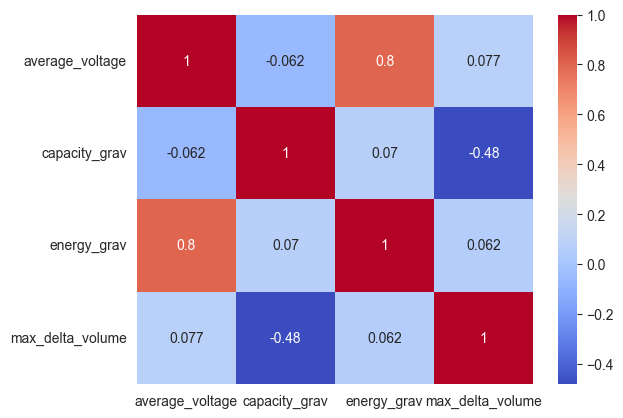

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(mp_df[["average_voltage", "capacity_grav", "energy_grav","max_delta_volume",]].corr(),
            annot=True, cmap="coolwarm")
plt.show()


Positive Correlation:
        1. average_voltage and energy_grav
Negative Correlation
        1. max_delta_volume and capacity_grav